Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ricca\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\User

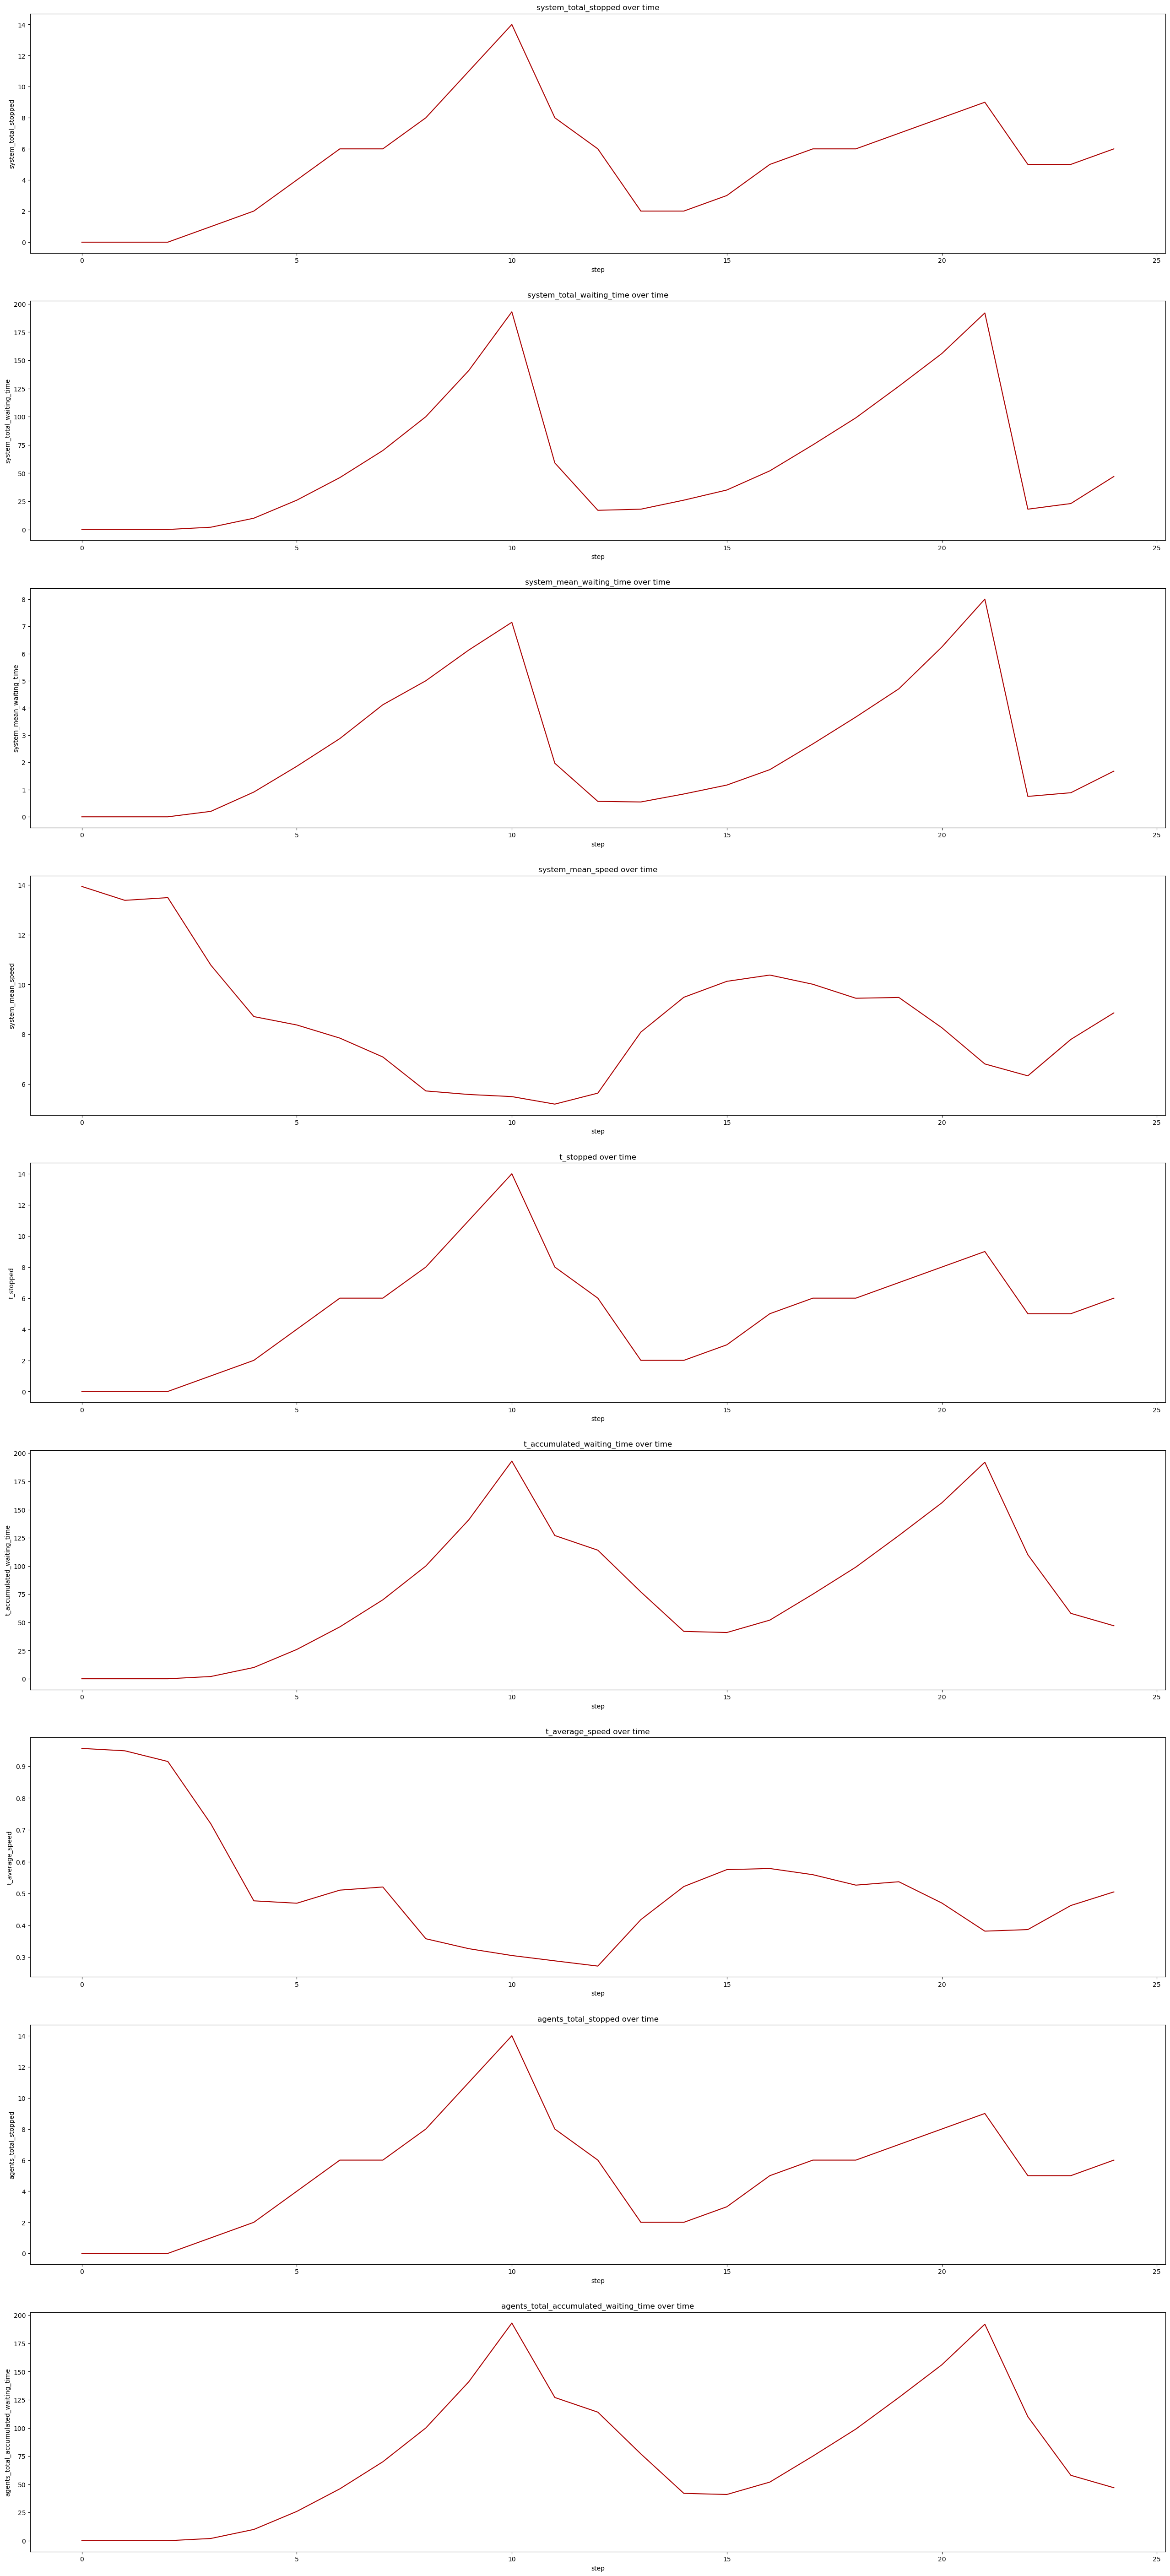

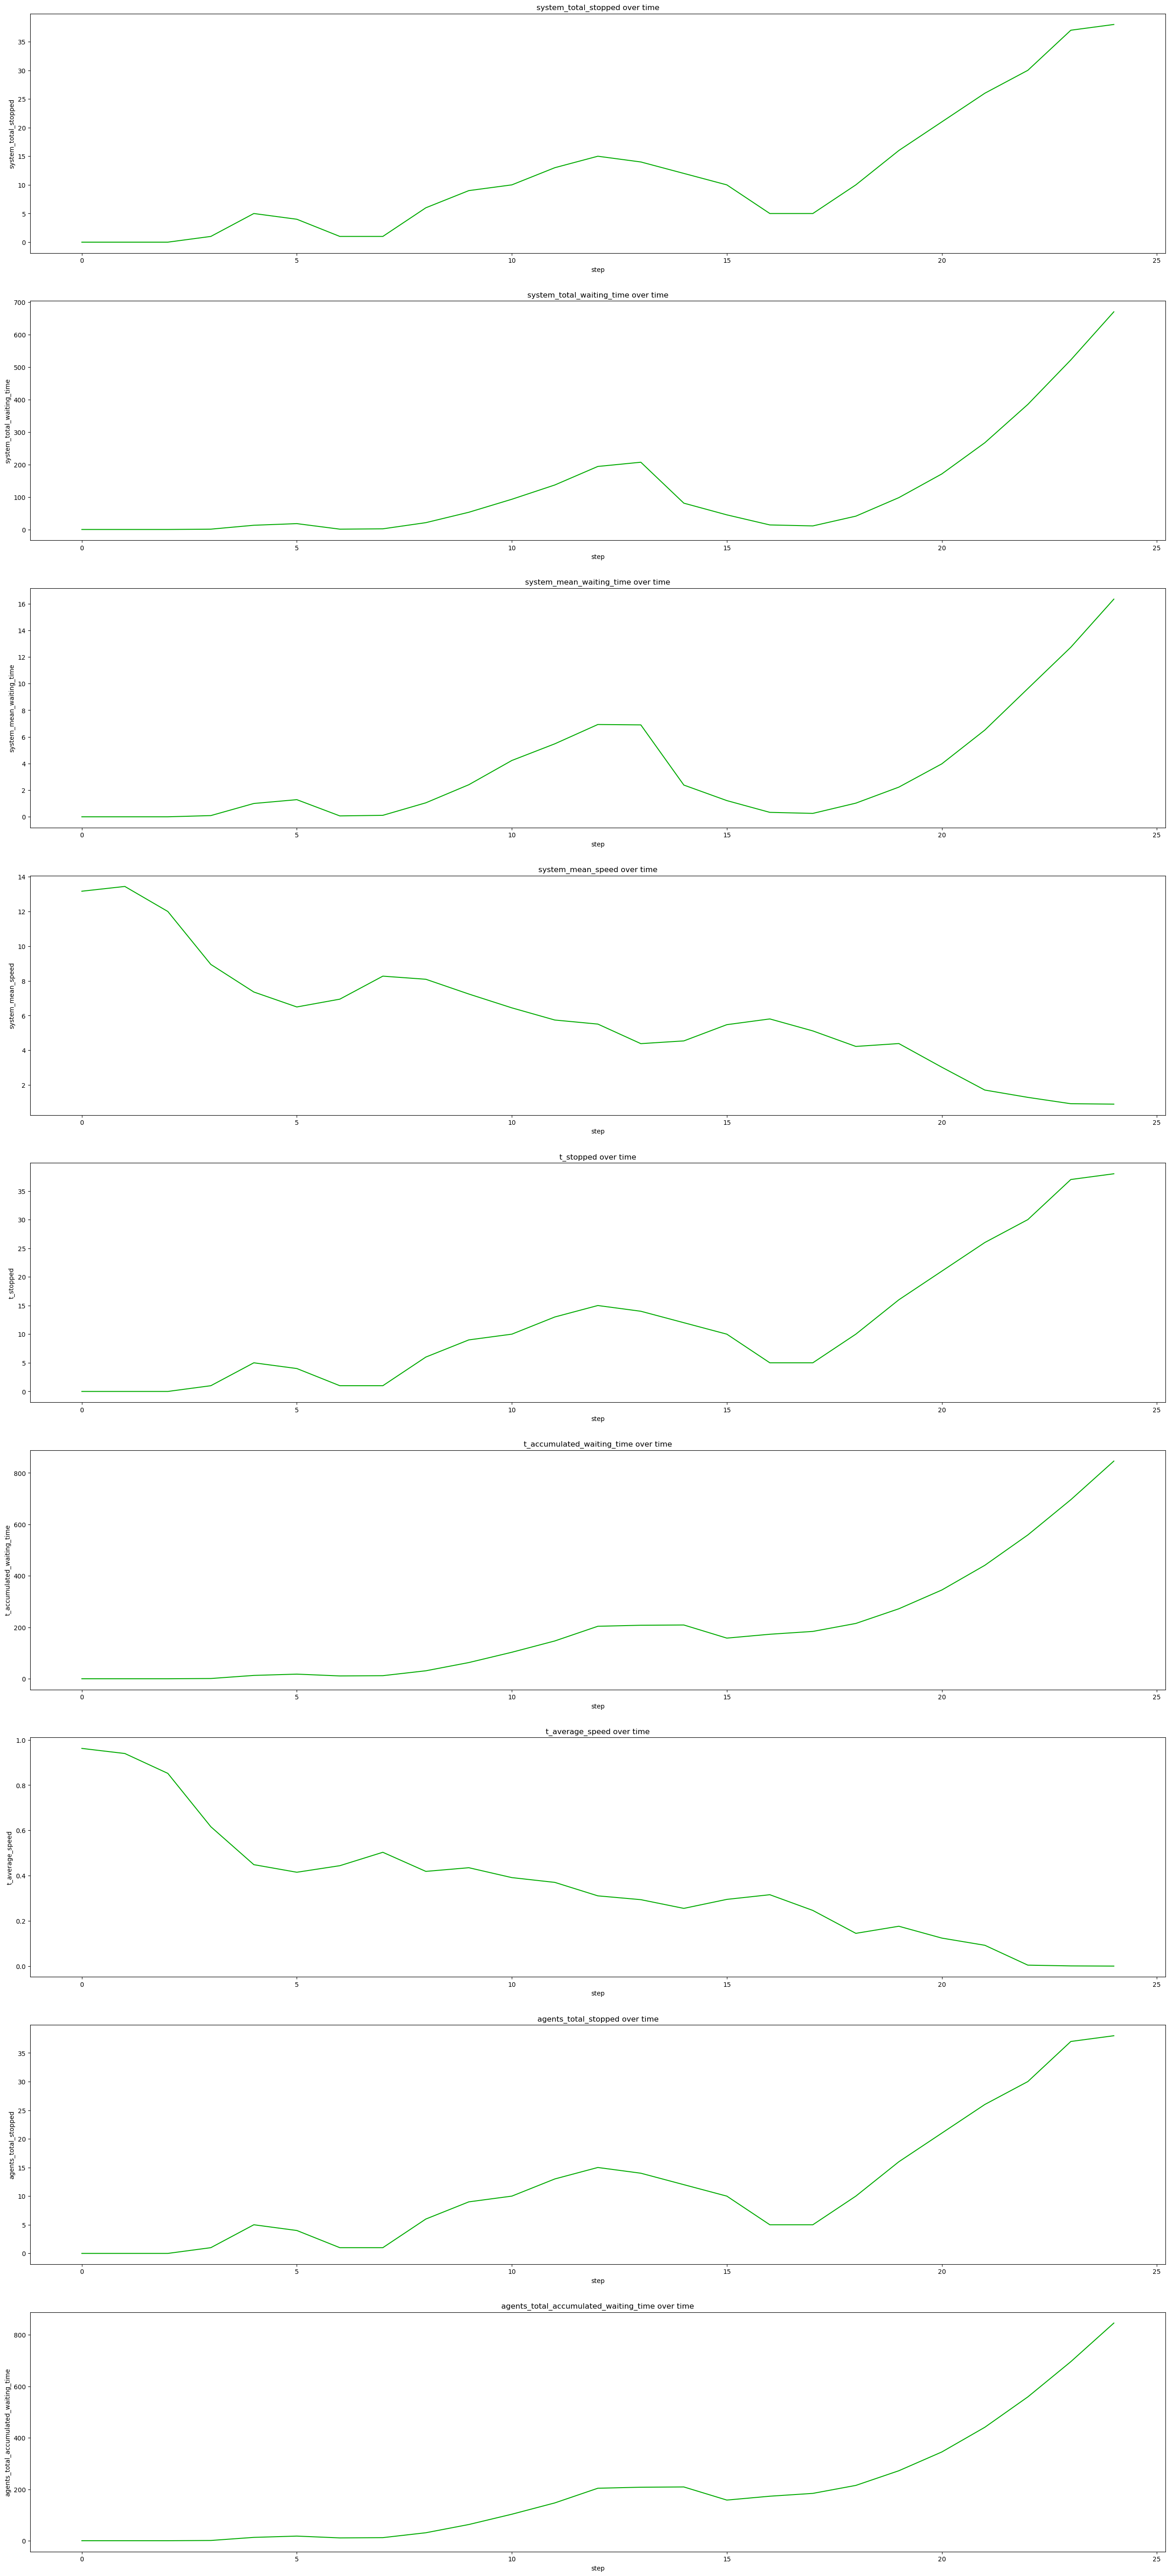

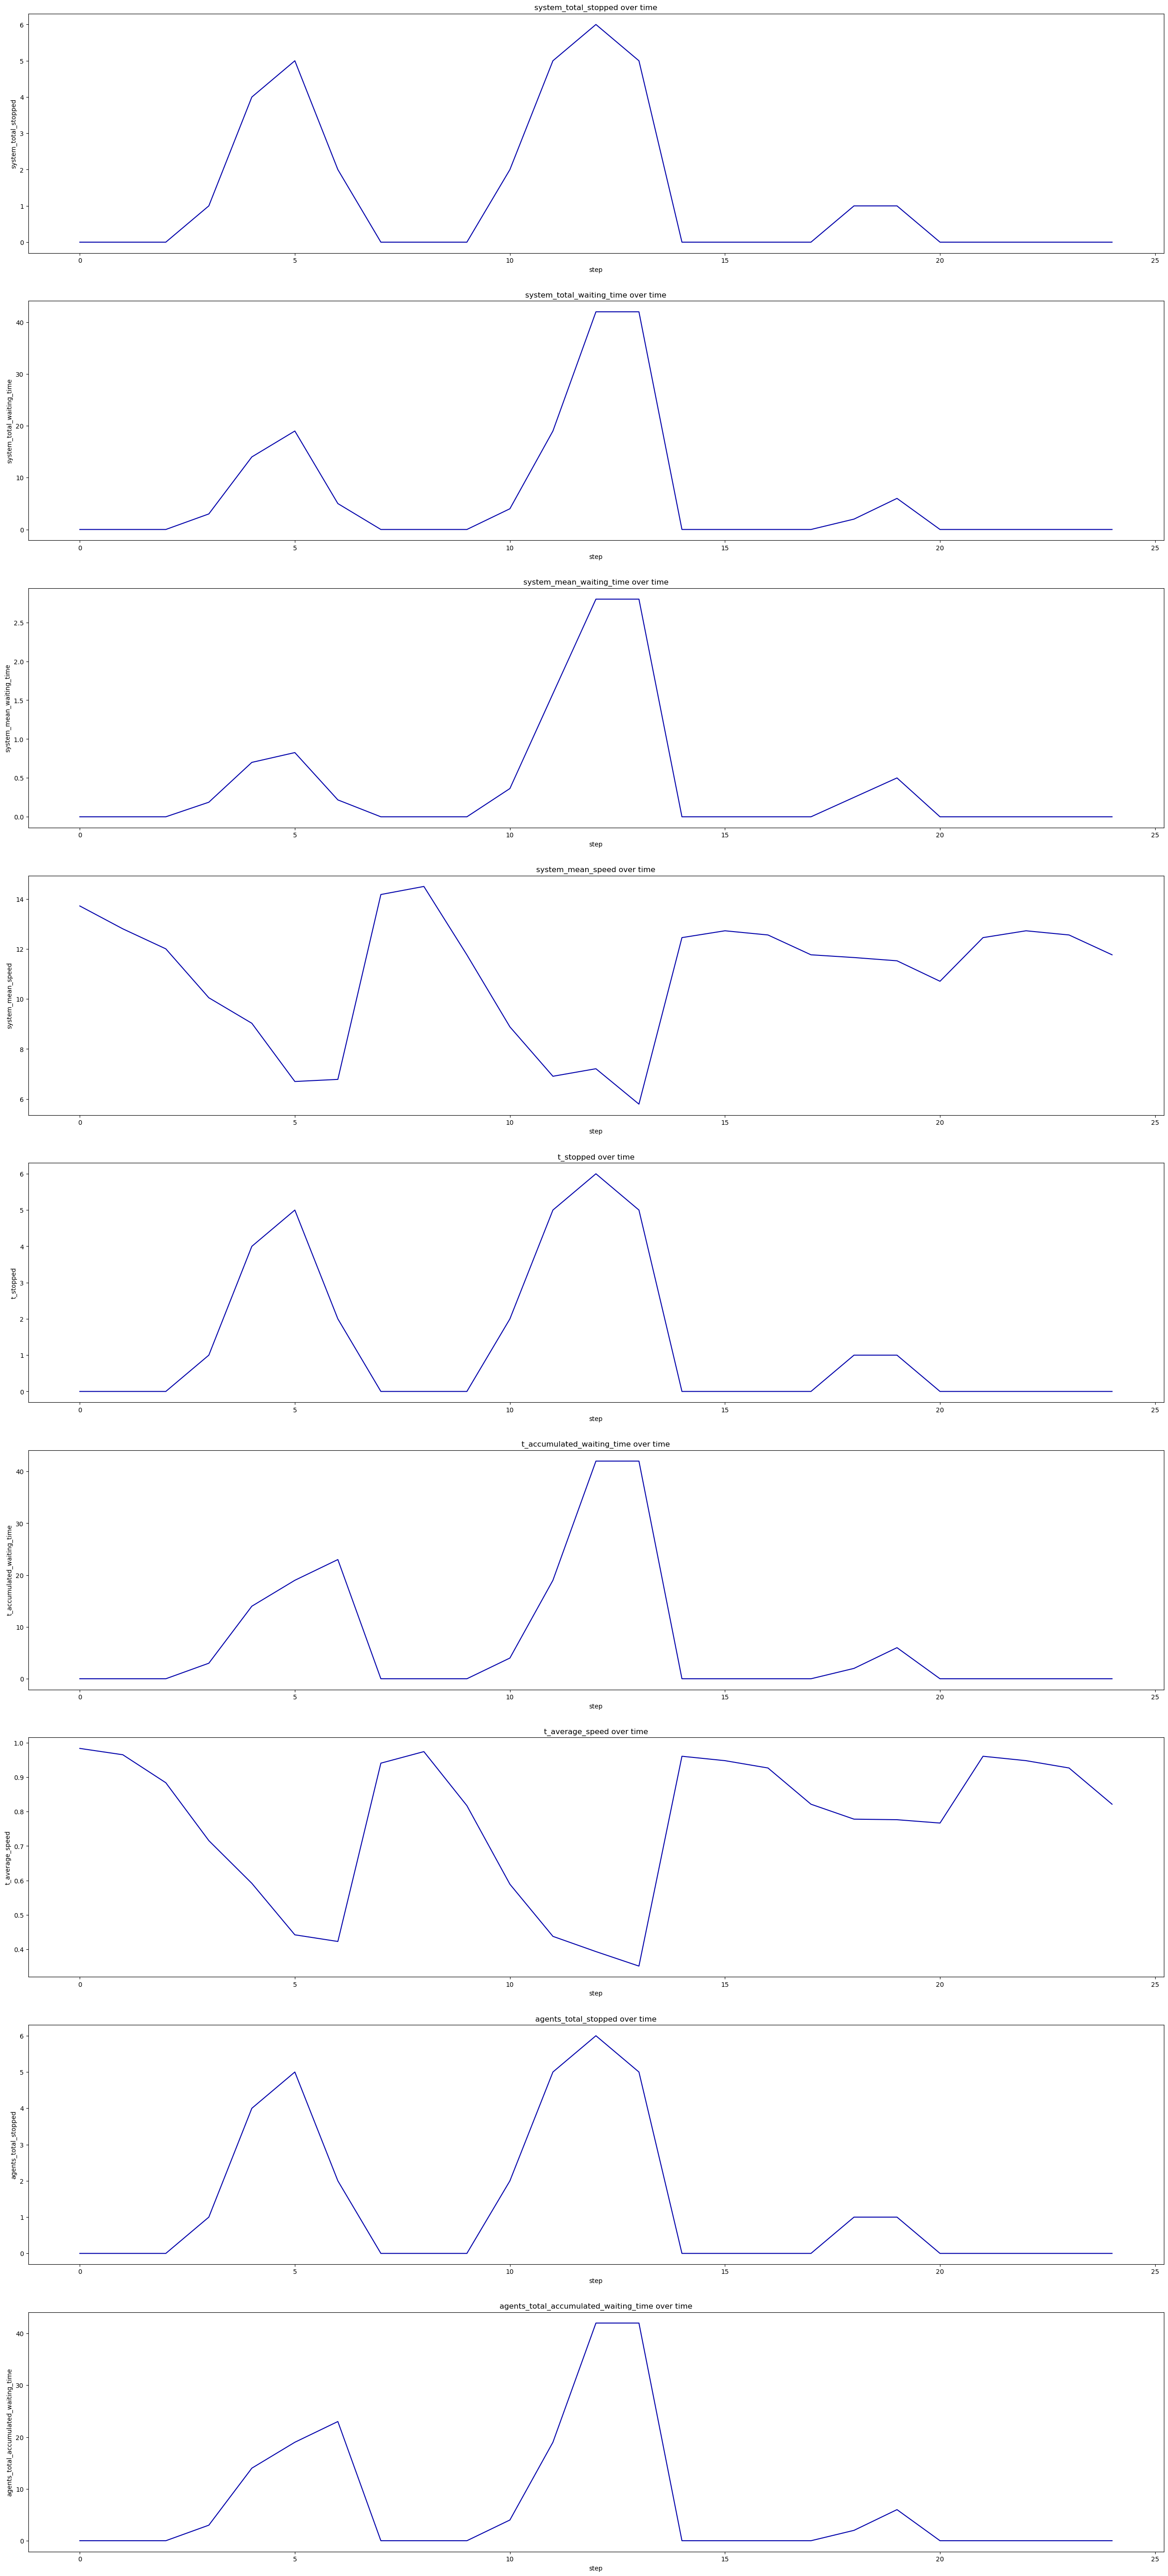

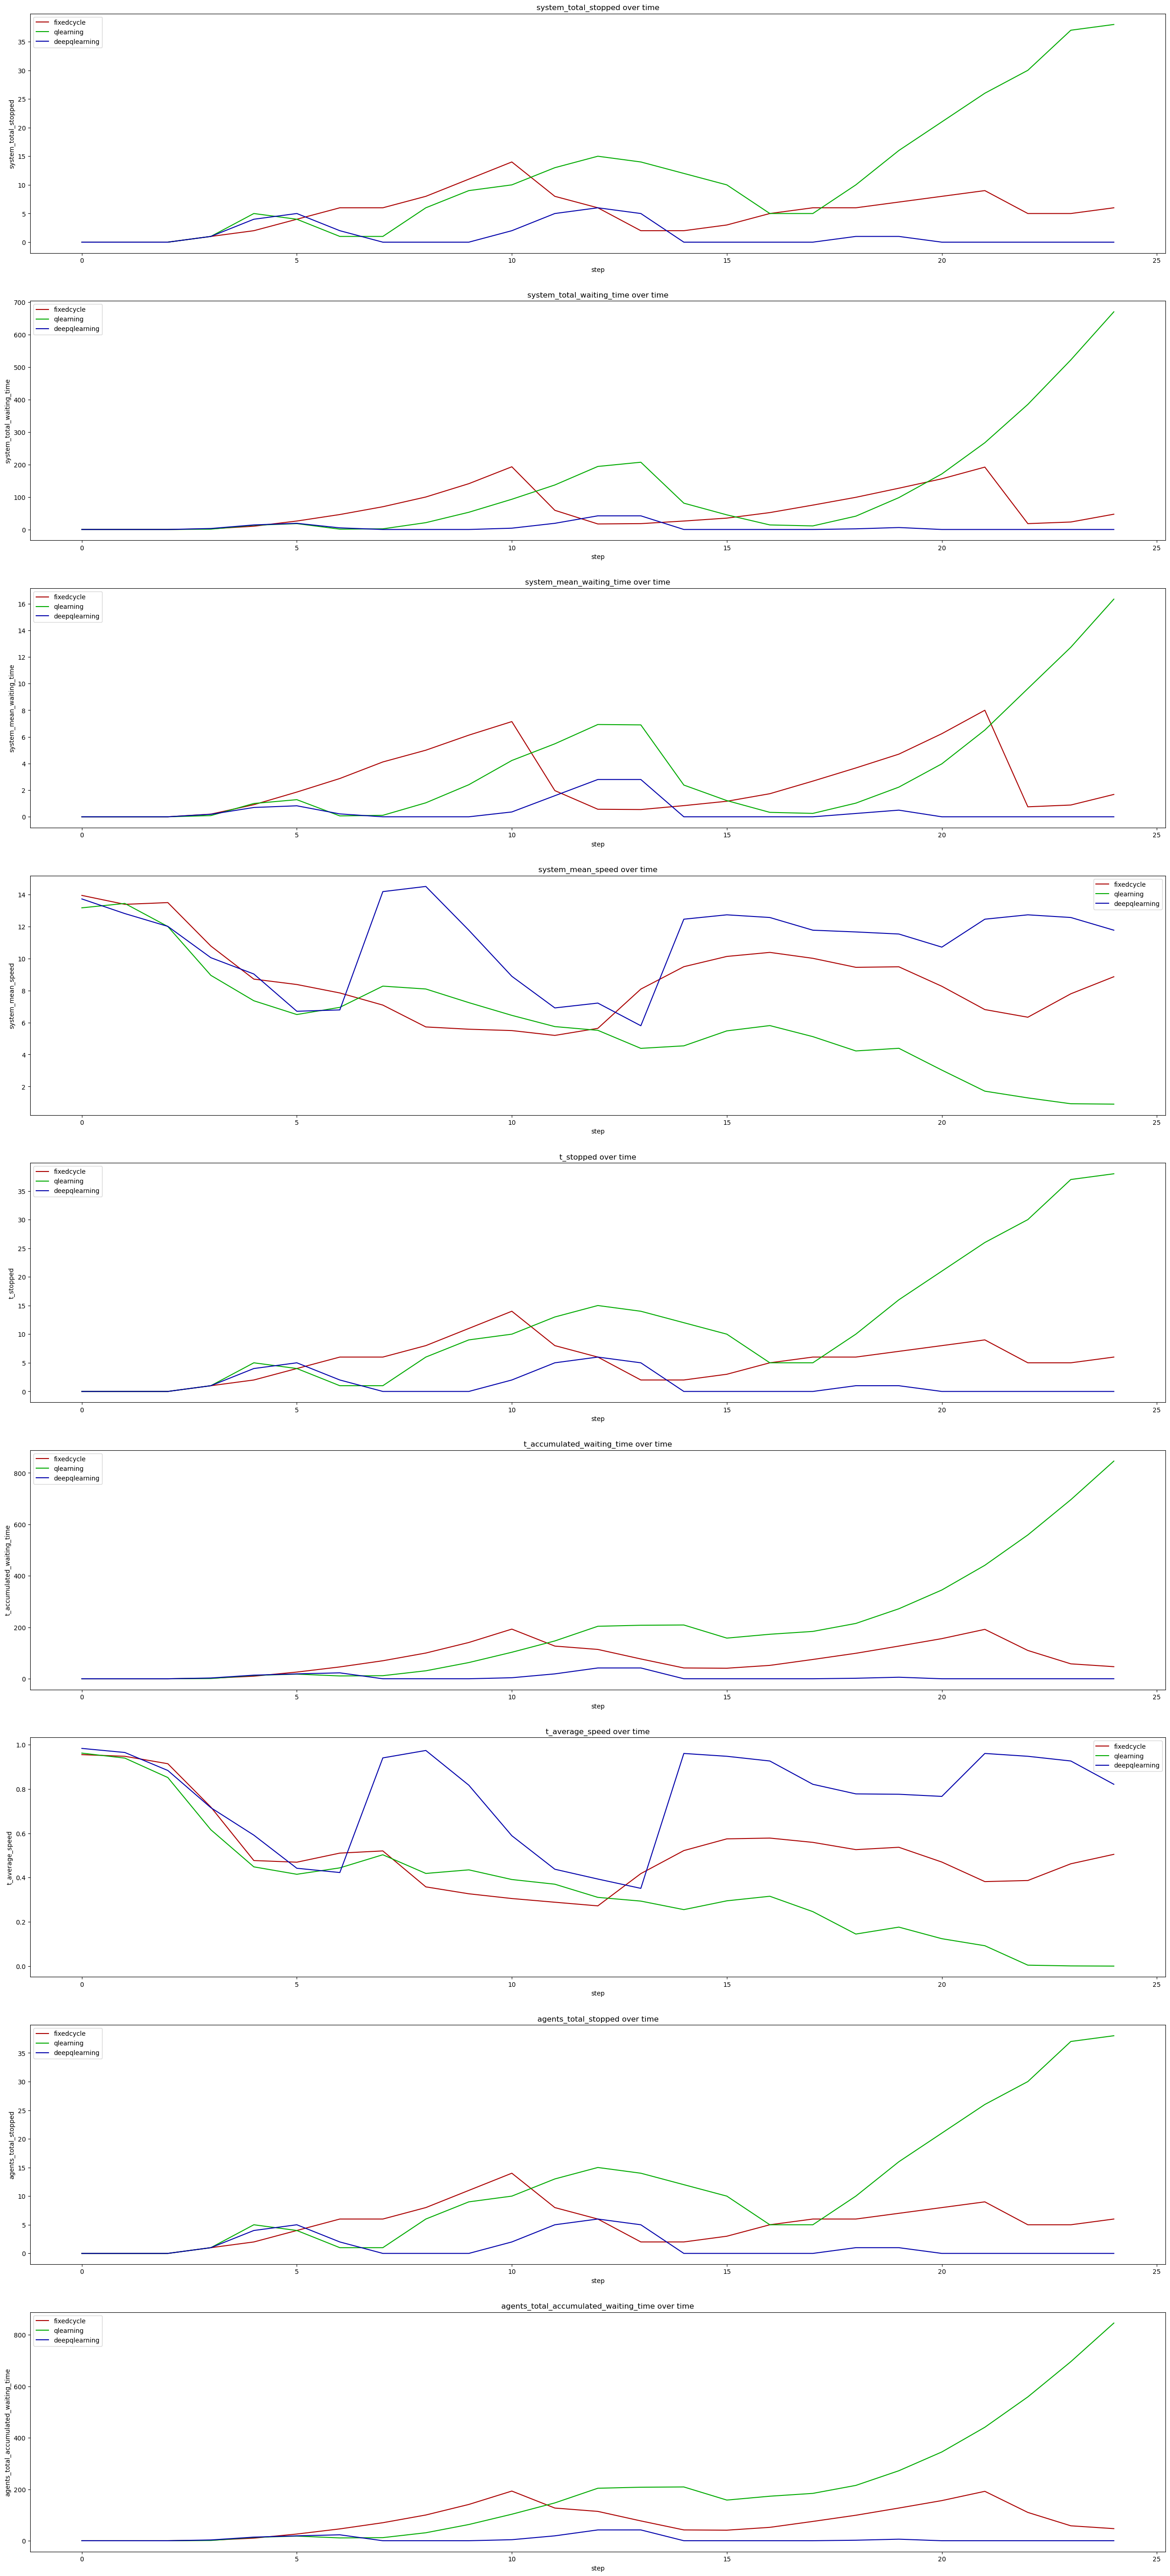

In [1]:
%matplotlib inline
from agents.trafficagent import TrafficAgent, FixedCycleTrafficAgent, QLearningTrafficAgent, DeepQLearningTrafficAgent
from utils.plotter import Metric, MultiPlotter

seconds = 100
delta_time = 4
yellow_time = 3
min_green = 5
max_green = 30

agents: dict[str, TrafficAgent] = {
  'fixedcycle': FixedCycleTrafficAgent(
    'fixedcycle',
    '#aa0000',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    delta_time,
    yellow_time,
    min_green,
    max_green
  ),
  'qlearning': QLearningTrafficAgent(
    'qlearning',
    '#00aa00',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    delta_time,
    yellow_time,
    min_green,
    max_green
  ),
  'deepqlearning': DeepQLearningTrafficAgent(
    'deepqlearning',
    '#0000aa',
    'nets/single-intersection/single-intersection.net.xml',
    'nets/single-intersection/single-intersection.rou.xml',
    seconds,
    delta_time,
    yellow_time,
    min_green,
    max_green
  )
}
metrics: list[Metric] = [
  'system_total_stopped',
  'system_total_waiting_time',
  'system_mean_waiting_time',
  'system_mean_speed',
  't_stopped',
  't_accumulated_waiting_time',
  't_average_speed',
  'agents_total_stopped',
  'agents_total_accumulated_waiting_time'
]

multi_plotter = MultiPlotter(
  list(map(lambda agent: {'name': agent.name, 'color': agent.color}, list(agents.values()))),
  metrics,
  seconds,
  1
)

for agent in agents:
  agents[agent].learn(multi_plotter.append)

multi_plotter.save()